# Random Forest

In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import sys; sys.path.append('/Users/uqhkamel/PhD/Code/AKI_mimiciv/mimic-code-main/mimic-iv/src')
import pandas as pd
import matplotlib.pyplot as plt


import numpy as np
import sqlite3

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score


from pickle import dump
# from dfwiz import dfwiz

from sklearn.ensemble import RandomForestClassifier

from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import StratifiedKFold


from sklearn.metrics import recall_score


# from sklearn.pipeline import Pipeline


from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE



from sklearn.experimental import enable_iterative_imputer

from sklearn.impute import IterativeImputer

from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import resample

import copy

from sklearn import metrics


from utils.vis import spy, look, plot_nunique, plot_dists
from utils.processing import sort, impute, replace_inf, drop_empty, select, drop_by_nunique, scale, melt, unmelt, \
                             remove_outliers, get_categories, filter_categorical, onehot, filter_regex, match, cap,get_dates


In [38]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import numpy as np
pd.set_option("display.max_columns", None)

In [39]:
# global variables representing experiment parameters
EXPERIMENT = 'Processing Demo'
IMPUTE_NUM = 'constant'
IMPUTE_CAT = 'other'
FIGSIZE    = [12,3]

# parameter dict
params = {
    'experiment':EXPERIMENT,
    'figsize'   :FIGSIZE,
    'impute_num':IMPUTE_NUM,
    'impute_cat':IMPUTE_CAT,
}

_________
### upsampler func def

In [40]:
from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

class upsampler(BaseEstimator, TransformerMixin): 
    def __init__(self):
        return None
    
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        return X

    def sample(self, X, y = None):
        X = np.array(X)
        y = np.array(y)
        if len(y[y == 0]) < len(y[y == 1]):
            X1, y1 = resample(X[y[y == 0]], y[y == 0], random_state=0, n_samples=len(y[y == 1]))
            X2, y2 = X[y[y == 1]], y[y == 1]
        else:
            print(X[y[y == 0]].shape)
            X1, y1 = resample(X[y[y == 1]], y[y == 1], random_state=0, n_samples=len(y[y == 0]))
            X2, y2 = X[y[y == 0]], y[y == 0]
        X_out = np.vstack((X1, X2))
        y_out = np.hstack((y1, y2))  

        return X_out, y_out


_________
### accuracy func def

In [41]:
def confusion_matrix_plot(y, y_pred, y_pred_proba):

    fpr, tpr, _ = metrics.roc_curve(y,   y_pred_proba[::,1])
    score = metrics.roc_auc_score(y,  y_pred_proba[::,1])

    #create ROC curve
    plt.plot(fpr,tpr,label="score="+str(score))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()


    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(7,7))
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()
    
    accuracy = accuracy_score(y, y_pred)

    # print("Accuracy: %.2f%%" % (accuracy * 100.0))


    cr = classification_report(y, y_pred)
    print("\r\n"+"Classification report"+"\r\n")
    print(cr)

    print("\r\n_________________________________________")



In [42]:
from sklearn.utils import resample

def up_sample(X_train_raw, y_train_raw,col_name):

    # upsampling X_train and y_train
    df_upsampled = pd.merge(X_train_raw, y_train_raw, left_index=True, right_index=True)

    X_minority = df_upsampled[df_upsampled[col_name]==1]
    X_majority = df_upsampled[df_upsampled[col_name]!=1]

    n_samples = X_majority.shape[0]
    X_minority_upsampled = resample(X_minority,
                                    replace=True,     # sample with replacement
                                    n_samples=n_samples,    # to match majority class
                                    random_state=42) # reproducible results

    df_upsampled = pd.concat([X_majority, X_minority_upsampled]).sample(frac=1)

    y_train_out = df_upsampled[[col_name]]
    X_train_out = df_upsampled.drop([col_name], axis=1)

    return X_train_out, y_train_out

_________
### define cross validation function

In [43]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold



def param_graph(X_train, y_train, pipe, param_grid, cv=5, max_iter = 5, sample_ratio = 0.2, refit=True, use_error=True):

    print("This search selects lower indexes of search list if their score is within the error of maximum score.")
    print("Putting parameters for less complicated model on the left side of the grid lists leads to better generalisation. ")
    print(" ")

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    n_train = int(sample_ratio * len(y_train))
    X_train_s, y_train_s  = resample(X_train, y_train, n_samples=n_train, stratify=y_train)

    best_score = {}
    best_params = {}
    for k, v in param_grid.items():
        # best_params[k] = v[int(len(v)/2)-1]
        best_params[k] = v[0]
    best_params_m1 = best_params.copy()
    print("start_params:", best_params)

    score = {}
    score_std = {}

    for i_iter in range(max_iter):
        print("_"*100)
        print("Iteration", i_iter)

        for k, v in param_grid.items():

            best_params1 = best_params.copy()
            del best_params1[k]  

            score[k] = v.copy()
            score_std[k] = v.copy()

            for i_param, val_param in enumerate(v):
                cv_sc = np.zeros(cv)

                for i_cv in range(cv):

                    X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train_s, y_train_s, test_size=0.2, stratify=y_train_s, shuffle=True) # 80% training and 20% test

                    p1 = copy.deepcopy(pipe)
                    p1.set_params(**best_params1)
                    params2 = {k:val_param}
                    p1.set_params(**params2)

                    p1.fit(X_train2, y_train2.ravel())
                    # X,y = p1.named_steps['resample'].fit_resample(X_test2, y_test2)
                    X,y = X_test2, y_test2
                    # y_pred_proba = p1.predict_proba(X)
                    # cv_sc[i_cv] = metrics.roc_auc_score(y,  y_pred_proba[::,1])
                    y_pred = p1.predict(X)
                    cv_sc[i_cv] = metrics.f1_score(y, y_pred)

                    i_cv = i_cv + 1

                score[k][i_param] = cv_sc.mean()
                score_std[k][i_param] = cv_sc.std()

            print("")
            print(k)
            print(v)
            print(score[k])

            best_params[k] = v[np.argmax(score[k])]
            best_score[k] = score[k][np.argmax(score[k])]

            if use_error:
                for i_b in  range(np.argmax(score[k]),-1,-1):
                    err1 = (score_std[k][i_b] + score_std[k][v.index(best_params[k])] ) / 4
                    # print("err1")
                    max_del = max(score[k]) - err1
                    # print( i_b, score[k][i_b], max(score[k]), err1, max_del )
                    if score[k][i_b] >= max_del:
                        best_params[k] = v[i_b]
                        best_score[k] = score[k][i_b]

            print("best_param:",  v[np.argmax(score[k])], "score:", max(score[k]))
            print("selected_param:",  best_params[k], "score:", best_score[k])
            

        
        print("")
        print("best_params =", best_params)
        print("")
        if best_params_m1 == best_params:
            print("")
            print("")
            print("Early stop. No improvement in the last iteration.")
            break
        best_params_m1 = best_params.copy()

    param_graph_plot(score)

    if refit:
        print("Refitting final model...")
        model_final = copy.deepcopy(pipe)
        model_final.set_params(**best_params)
        model_final.fit(X_train, y_train.values.ravel())
    else:
        model_final = None

    return score, best_params, model_final
    

def param_graph_plot(score):
    ax = {}
    fig = {}
    for i, (k, v) in enumerate(score.items()):
        fig[k], ax[k] = plt.subplots()

    for k, v in score.items():
        x = score[k]
        y = v
        ax[k].plot(x,y,"-o", label="Score")
        # ax[k].set_ylim([0.5, 1])
        ax[k].set_title(k)
        ax[k].legend()

________
### Define upsampler

In [44]:

from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.utils import resample


class upsampler(BaseEstimator): 
    def __init__(self):
        return None

    def fit_resample(self, X, y = None):
        X = np.array(X)
        y = np.array(y).ravel()
        if len(y[y == 0]) < len(y[y == 1]):
            X1, y1 = resample(X[y == 0], y[y == 0], random_state=0, n_samples=len(y[y == 1]))
            X2, y2 = X[y == 1], y[y == 1]
        else:
            X1, y1 = resample(X[y == 1], y[y == 1], random_state=0, n_samples=len(y[y == 0]))
            X2, y2 = X[y == 0], y[y == 0]
        X_out = np.vstack((X1, X2))
        y_out = np.hstack((y1, y2))  
        return X_out, y_out

________
### Load data and select index

In [45]:
# get table from database
# database = "data.sqlite"
# con = sqlite3.connect(database)

# X_train = pd.read_sql_query("SELECT * from X_train", con)
# y_train = pd.read_sql_query("SELECT * from y_train", con)
# # select index
# index_c = ['USUBJID'] # empty list for no index
# X_train = X_train.set_index(index_c)
# y_train = y_train.set_index(index_c)

# X_train1 = X_train[~X_train.scr_umol_l.isna()]
# y_train1 = y_train[~X_train.scr_umol_l.isna()]

# X_test = pd.read_sql_query("SELECT * from X_test", con)
# y_test = pd.read_sql_query("SELECT * from y_test", con)
# # select index
# index_c = ['USUBJID'] # empty list for no index
# X_test = X_test.set_index(index_c)
# y_test = y_test.set_index(index_c)

# y_test = y_test[~X_test.scr_umol_l.isna()]
# X_test = X_test[~X_test.scr_umol_l.isna()]


# X_train, y_train  = resample(X_train, y_train, n_samples=5000, stratify=y_train)
# X_test, y_test  = resample(X_test, y_test, n_samples=1000, stratify=y_test)





In [46]:
# create a database connection
sqluser = 'uqhkamel'
dbname = 'mimiciv'
schema_name = 'mimic_derived'

In [47]:
# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser)
cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema_name))

In [48]:
query = "select * from AKI_ICU_JOIN_day1plus_SD"
data = pd.read_sql_query(query,con,index_col=['stay_id','subject_id','hadm_id'])

In [49]:
data['ethnicity'] = data['ethnicity'].replace(['OTHER'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['UNKNOWN'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['UNABLE TO OBTAIN'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['UNABLE TO OBTAIN'],np.nan)
data['ethnicity'] = data['ethnicity'].replace(['AMERICAN INDIAN/ALASKA NATIVE'],np.nan)

data = data.fillna(value=np.nan)


In [50]:
data.shape

(26612, 99)

In [51]:
# data['creatinine_max']=data['creatinine_max']**(1/2)
# data['creatinine_min']=data['creatinine_min']**(1/2)

In [52]:
# aki_kdigo = ['aki_kdigo_grade_1','aki_kdigo_grade_2','aki_kdigo_grade_3']

# outcome_var = ['day_detection_kdigo_grade_1','day_detection_kdigo_grade_2','day_detection_kdigo_grade_3']

outcome_var = []
outcome_var.append('min_day_rrt_present')


first_24h = 1
data= data[data[outcome_var].min(axis=1)>first_24h]

In [53]:
(data.egfr_mrdr_scr_max<60).sum()

6325

In [54]:
data = data[data['ckd']==0]

In [55]:
data = data[data['kidney_transplant']==0]

In [56]:
data = data[data['egfr_epi_scr_max']>60]

In [57]:
data.dropna(axis=1, thresh = int(0.7*data.shape[0]), inplace=True)

In [58]:
pd.set_option('display.max_rows', None)

In [59]:
data.isna().sum()/len(data)*100

aki_kdigo_grade_1                   0.000000
aki_kdigo_grade_2                   0.000000
aki_kdigo_grade_3                   0.000000
day_detection_kdigo_grade_1         0.000000
day_detection_kdigo_grade_2         0.000000
day_detection_kdigo_grade_3         0.000000
aki_mkdigo_grade_1                  0.000000
aki_mkdigo_grade_2                  0.000000
aki_mkdigo_grade_3                  0.000000
day_detection_mkdigo_grade_1        0.000000
day_detection_mkdigo_grade_2        0.000000
day_detection_mkdigo_grade_3        0.000000
age                                 0.000000
female                              0.000000
ethnicity                          17.414546
ckd                                 0.000000
kidney_transplant                   0.000000
mhx_coronary_artery_disease         0.000000
mhx_congestive_heart_failure        0.000000
mhx_diabetes                        0.000000
mhx_liver_failure                   0.000000
mhx_myocardial_infarction           0.000000
mhx_periph

In [60]:
# data.isna().sum()/len(data)*100

In [61]:
# data = data[data['egfr_mrdr_scr_max']>=100]

In [62]:
prediction_window = 2

In [63]:
data.loc[(((data['aki_kdigo_grade_1']== 1)| (data['aki_kdigo_grade_2']== 1) | (data['aki_kdigo_grade_3']==1)) \
    &( (data['day_detection_kdigo_grade_1']<=prediction_window)| (data['day_detection_kdigo_grade_2']<=prediction_window) | (data['day_detection_kdigo_grade_3']<=prediction_window)) \
        |(data['min_day_rrt_present']<= prediction_window)), 'outcome'] = 1


data.loc[data.outcome.isna(),'outcome']=0

In [64]:
drop_X   = [
'day_detection_kdigo_grade_1',
'day_detection_kdigo_grade_2',
'day_detection_kdigo_grade_3',
'day_detection_mkdigo_grade_1',
'day_detection_mkdigo_grade_2',
'day_detection_mkdigo_grade_3',
'min_day_rrt_active',
'min_day_rrt_present',
'ckd'
]
# CRP and vomit_nausea as they had mostly empty

data.drop(drop_X, inplace=True, axis=1)

In [65]:
data.shape

(19455, 80)

In [66]:
data.aki_kdigo_grade_1.value_counts()

0    16565
1     2890
Name: aki_kdigo_grade_1, dtype: int64

In [67]:
data.aki_kdigo_grade_2.value_counts()

0    19072
1      383
Name: aki_kdigo_grade_2, dtype: int64

In [68]:
data.aki_kdigo_grade_3.value_counts()

0    19387
1       68
Name: aki_kdigo_grade_3, dtype: int64

## Missingness percentage

In [69]:
data.shape

(19455, 80)

In [70]:
# data.reset_index().drop_duplicates(subset=['stay_id','subject_id','hadm_id']).set_index(['stay_id','subject_id','hadm_id'])

In [71]:
# # remove unpopulated columns
# data.pipe(sort)\
#               .pipe(replace_inf).pipe(drop_empty)

In [72]:
# split by column type
data_num = data.pipe(sort).pipe(replace_inf).pipe(drop_empty).pipe(select, 'numerical')

data_cat = data.pipe(sort).pipe(replace_inf).pipe(drop_empty).pipe(select, 'categorical')

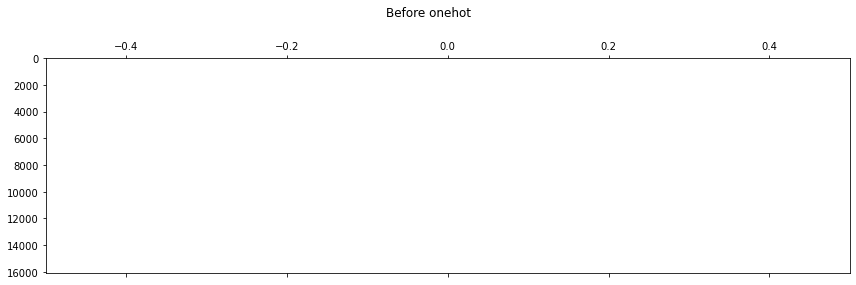

In [73]:
data_cat = data_cat.pipe(filter_categorical, cutoff=20, plot=False)\
                                            .pipe(sort).pipe(spy, title='Before onehot', figsize=[12,4])\
                                            .fillna('other').pipe(onehot)

In [74]:
data_cat.head(5)

len                                             
variable            ethnicity                                             
value                   ASIAN BLACK/AFRICAN AMERICAN HISPANIC/LATINO WHITE
stay_id  subject_id                                                       
30001656 19609454           0                      0               0     1
30001947 15904173           0                      0               0     1
30002415 17921898           0                      0               0     1
30002498 17938576           0                      0               0     1
30002548 14311522           0                      0               0     1

In [75]:
processed = pd.merge(data_num, data_cat, left_index=True, right_index=True)

In [76]:
processed.columns

Index([                           'aki_kdigo_grade_1',
                                 'aki_mkdigo_grade_1',
                                 'aki_mkdigo_grade_2',
                                  'kidney_transplant',
                                  'aki_kdigo_grade_3',
                                  'aki_kdigo_grade_2',
                                 'aki_mkdigo_grade_3',
                                             'female',
                                                'age',
                        'mhx_coronary_artery_disease',
                       'mhx_congestive_heart_failure',
                                       'mhx_diabetes',
                                            'outcome',
                                  'mhx_liver_failure',
                    'mhx_peripheral_vascular_disease',
                                  'mhx_renal_failure',
                                     'creatinine_min',
                                     'creatinine_max',
          

In [77]:
drop_X   = [
    'aki_kdigo_grade_1',
    'aki_mkdigo_grade_1',

    'aki_kdigo_grade_2',
    'aki_mkdigo_grade_2',

    'aki_kdigo_grade_3',
    'aki_mkdigo_grade_3'
]
 
select_y = ['outcome']

processed_X = processed.pipe(filter_regex, drop_X+select_y)
processed_Y = processed.filter(regex='|'.join(select_y))
raw_Y = data_num.pipe(replace_inf).pipe(drop_empty).filter(regex='|'.join(select_y))
df_y = raw_Y[select_y]


df_X, df_y = match(processed_X, df_y)

In [78]:
df_y.value_counts()

outcome
0.0        14404
1.0         1663
dtype: int64

In [79]:
df_X.columns

Index([                                'chloride_min',
                                      'resp_rate_max',
                                     'creatinine_min',
                                  'mhx_liver_failure',
                                      'potassium_max',
                                         'wbc_bd_max',
                                            'sbp_max',
                        ('len', 'ethnicity', 'ASIAN'),
                                       'tracheostomy',
                                             'pt_min',
                       'mhx_congestive_heart_failure',
                                'supplemental_oxygen',
                          'mhx_myocardial_infarction',
                                           'spo2_max',
                                  'egfr_mrdr_scr_max',
                                       'aniongap_min',
                                            'ptt_max',
                                     'heart_rate_max',
          

In [80]:
X, y = df_X, df_y

from sklearn.model_selection import train_test_split

X, y = df_X, df_y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

# X_train, y_train  = resample(X_train, y_train, n_samples=5000, stratify=y_train)
# X_test, y_test  = resample(X_test, y_test, n_samples=1000, stratify=y_test)

In [ ]:
# X_train, y_train = up_sample(X_train, y_train,'outcome')

In [ ]:
# from imblearn.under_sampling import RandomUnderSampler


# # define undersample strategy
# undersample = RandomUnderSampler(sampling_strategy='majority')
# # fit and apply the transform
# X_train, y_train = undersample.fit_resample(X_train, y_train)

___________________
### Define pipeline

In [87]:
import lightgbm as lgbm  # standard alias

pipe = Pipeline(steps=[
('resample', upsampler()),
('scaler', MinMaxScaler()),
('imputer',IterativeImputer(max_iter=10, random_state=42, missing_values=np.nan)),
('model', lgbm.LGBMClassifier(n_jobs=-1, n_estimators=300))
])

___________________
### Cross validation search

In [ ]:
########### **************************************8
# Make sure simpler models are at the start of array. The search picks numbers on the left side if they are within the error of maximum score.   


param_grid ={'model__num_leaves': [6, 10, 20, 50], 
             'model__min_child_samples': [100, 200, 300, 400, 500], 
             'model__min_child_weight': [1e-5,  1e-2,  1,  1e2,  1e4],
             'model__subsample' : [0.2, 0.5, 0.8], 
             'model__reg_alpha': [0, 1e-1, 1, 5,  10, 50, 100],
             'model__reg_lambda': [0, 1e-1, 1,  10,  50, 100]}






score, best_params, model_final = param_graph(X_train, y_train, pipe, param_grid, cv=5, max_iter = 4, sample_ratio = 0.3, refit=False, use_error=True)

# dump(model_final , open('model_final_LGBM.pkl', 'wb'))

__________
### Fitting Pipeline one time

In [ ]:
param_graph_plot(score)

In [ ]:
param_grid ={'model__num_leaves': [6, 10, 20, 50], 
             'model__min_child_samples': [100, 200, 300, 400, 500], 
             'model__min_child_weight': [1e-5,  1e-2,  1,  1e2,  1e4],
             'model__subsample' : [0.2, 0.5, 0.8], 
             'model__reg_alpha': [0, 1e-1, 1, 5,  10, 50, 100],
             'model__reg_lambda': [0, 1e-1, 1,  10,  50, 100]}



______________________________________________________________________________________________________________________________________________________

Train Accuracy:



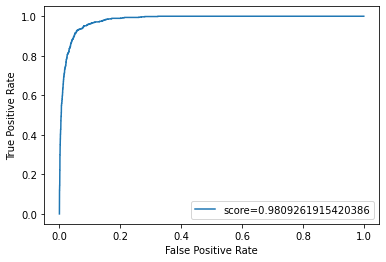

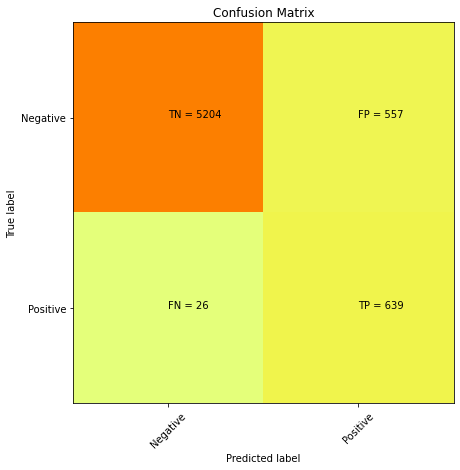


Classification report

              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95      5761
         1.0       0.53      0.96      0.69       665

    accuracy                           0.91      6426
   macro avg       0.76      0.93      0.82      6426
weighted avg       0.95      0.91      0.92      6426


_________________________________________


In [112]:
# manual params setting
best_params = {'model__num_leaves': 6, 'model__min_child_samples': 200, 'model__min_child_weight': 1e-5, 'model__subsample': 0.2, 'model__reg_alpha': 0.1, 'model__reg_lambda': 1e-1}

# Or get parameters from search above
best_params2 = best_params

sample_ratio = 0.5
n_samples = int(len(X_train)*sample_ratio)
X, y = resample(X_train.values, y_train.values, n_samples=n_samples, stratify=y_train.values, random_state=10)
model_final = copy.deepcopy(pipe)
model_final.set_params(**best_params2)
model_final.fit(X, y.ravel());


print("")
print("")
print("_"*150)
print("")
print("Train Accuracy:")
print("")

y_pred = model_final.predict(X)
y_pred_proba = model_final.predict_proba(X)

confusion_matrix_plot(y, y_pred, y_pred_proba)




# dump(model_final, open('pipe_rf.pkl', 'wb'))


__________
### Test accuracy

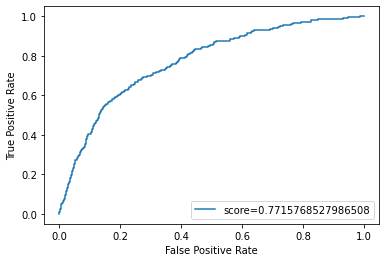

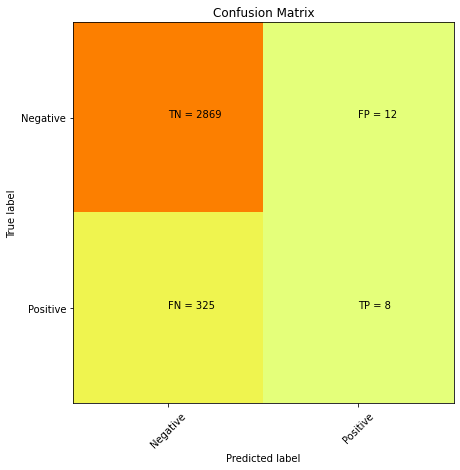


Classification report

              precision    recall  f1-score   support

         0.0       0.90      1.00      0.94      2881
         1.0       0.40      0.02      0.05       333

    accuracy                           0.90      3214
   macro avg       0.65      0.51      0.49      3214
weighted avg       0.85      0.90      0.85      3214


_________________________________________


In [113]:

# X,y = model_final.named_steps['resample'].fit_resample(X_test, y_test)
X,y = X_test.values, y_test.values

# y_pred = model_final.predict(X)
y_pred_proba = model_final.predict_proba(X)
y_pred  = (y_pred_proba[:,1] >= 0.9).astype(int)

confusion_matrix_plot(y, y_pred, y_pred_proba)


In [ ]:
df_y.value_counts()

In [ ]:
RF_model = model_final._final_estimator

In [ ]:
model_final.

In [ ]:
importances = RF_model.feature_importances_
indices = np.argsort(importances)

features = X_train.columns
plt.rcParams["figure.figsize"] = (12,12)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
# combining X_test,y_test and y_pred in one dataset
df_test_all = X_test.copy()
df_test_all['y_actual'] = y_test
df_test_all['y_pred'] = y_pred
# df_test_all

In [ ]:
# labeling the category of error

pd.options.mode.chained_assignment = None  # To suppress a warning for commands below 

df_test_all['error_category'] = 0 # create'error_category' column
for i in df_test_all.index:
     if df_test_all['y_actual'][i] == 0 and df_test_all['y_pred'][i] == 0: # True negative 0 
          df_test_all['error_category'][i] = 0
     if df_test_all['y_actual'][i] == 0 and df_test_all['y_pred'][i] == 1: # False positive 1
          df_test_all['error_category'][i] = 1
     if df_test_all['y_actual'][i] == 1 and df_test_all['y_pred'][i] == 1: # True positive 2
          df_test_all['error_category'][i] = 2
     if df_test_all['y_actual'][i] == 1 and df_test_all['y_pred'][i] == 0: # False negative 3
          df_test_all['error_category'][i] = 3

# df_test_all

In [ ]:
df_test_all.query("error_category == 1")[X_test.columns].head(100)

In [ ]:
# get data for True negative and  False positive and compare their distribution.
# It plots the distribution and prints Jensen-Shanon distance.
# from functions_compare_distribution import compare_hist_df
from dfwiz import dfwiz, dfwiz_compare
FP = df_test_all.query("error_category == 1")[X_test.columns] # True negative
TP = df_test_all.query("error_category == 2")[X_test.columns] # False positive

if len(FP) == 0 or len(TP) == 0:
    print("Error! one of the dataframes are empty")
else:
    # compare_hist_df(TN, FP) # plot distributions and output Jensen-Shanon distance.
    dfwiz_compare(FP, TP,label=['FP','TP'])